In [1]:
from matplotlib import image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import numpy 

%load_ext autoreload
%autoreload 2
torch.manual_seed(0)

from IPython.display import clear_output 
clear_output(wait = True)
import sys 
sys.path.append('..\..\..')
from models import DIFDensityEstimator,EMDensityEstimator, LocationScaleFlow, SoftmaxWeight
from utils.color_visual import *

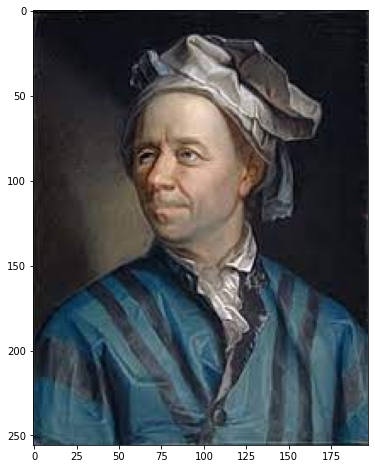

In [2]:
rgb = image.imread("euler.jpg")
figure = plt.figure(figsize = (12,8))
plt.imshow(rgb)
lines, columns = rgb.shape[:-1]

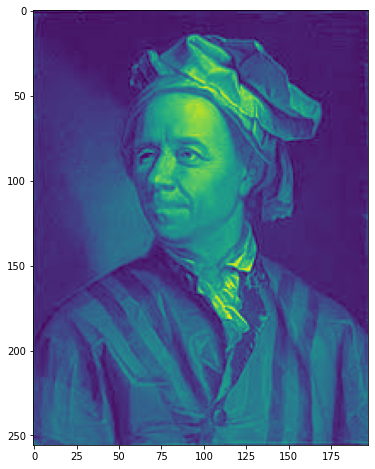

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
grey = torch.tensor(rgb2gray(rgb))
figure = plt.figure(figsize = (12,8))
plt.imshow(grey)

In [17]:
#Sample data according to image
vector_density = grey.flatten()
vector_density = vector_density/torch.sum(vector_density)
lignes, colonnes = grey.shape
num_samples = 100000
cat = torch.distributions.Categorical(probs = vector_density)
categorical_samples = cat.sample([num_samples])
target_samples = torch.cat([(categorical_samples//colonnes).unsqueeze(-1), (categorical_samples%colonnes).unsqueeze(-1)], dim = -1) + torch.rand([num_samples,2])

<ipython-input-17-faf434e2f674>:8: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  target_samples = torch.cat([(categorical_samples//colonnes).unsqueeze(-1), (categorical_samples%colonnes).unsqueeze(-1)], dim = -1) + torch.rand([num_samples,2])


In [18]:
#Save target samples
filename = 'euler_samples.sav'
torch.save(target_samples,filename)

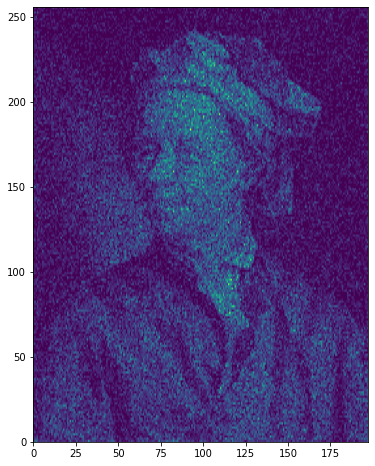

In [19]:
hist_target_samples, x_edges, y_edges = numpy.histogram2d(target_samples[:,1].numpy(), target_samples[:, 0].numpy(), bins = (lines, columns),range = [[0, columns],[0,lines]])
figure = plt.figure(figsize = (12,8))
plt.imshow(torch.flip(torch.flip(torch.tensor(hist_target_samples).T,[0,1]),[0,1]),extent = [0,columns,0, lines])

In [20]:
#Run EM
linspace_x = 5
linspace_y = 5
K = linspace_x*linspace_y
initial_m = torch.cartesian_prod(torch.linspace(0, lignes,linspace_x),torch.linspace(0, colonnes, linspace_y))
EM = EMDensityEstimator(target_samples,K)
EM.mu = initial_m
epochs = 50
EM.train(epochs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.35it/s, loss = 10.69663143157959]


In [21]:
#Save em
filename = 'euler_em.sav'
torch.save(EM,filename)

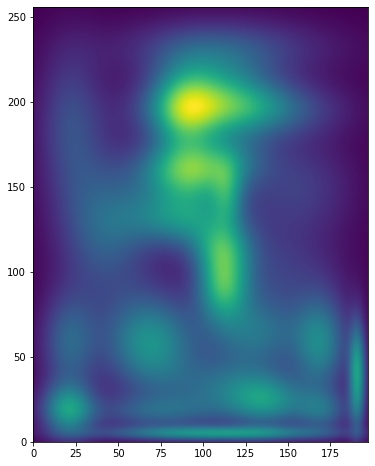

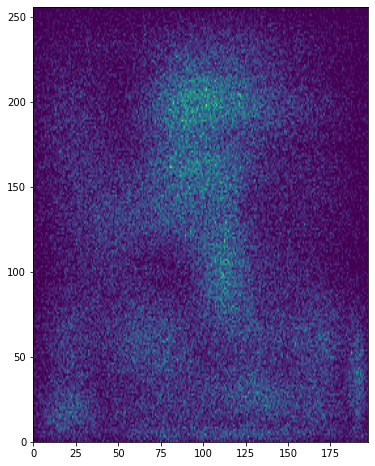

In [22]:
grid = torch.cartesian_prod(torch.linspace(0,lines,lines),torch.linspace(0,columns, columns))
density = torch.exp(EM.log_density(grid)).reshape(lines,columns).T.cpu().detach()
figure = plt.figure(figsize = (12,8))
plt.imshow(torch.flip(torch.flip(density.T,[0,1]),[0,1]),extent = [0,columns,0, lines])
EM_samples = EM.sample_model(target_samples.shape[0])
hist_EM_samples, x_edges, y_edges = numpy.histogram2d(EM_samples[:,1].numpy(), EM_samples[:, 0].numpy(), bins = (lines, columns), range = [[0, columns],[0,lines]])
figure = plt.figure(figsize = (12,8))
plt.imshow(torch.flip(torch.flip(torch.tensor(hist_EM_samples).T,[0,1]),[0,1]),extent = [0,columns,0, lines])

In [ ]:
#Run DIF with initialization EM
epochs = 100
batch_size = 20000
initial_T = LocationScaleFlow(K,2)
initial_T.m = nn.Parameter(EM.m)
initial_T.log_s = nn.Parameter(EM.log_s)

initial_w = SoftmaxWeight(K, 2, [128,128,128])
initial_w.f[-1].weight = nn.Parameter(torch.zeros(K, 128))
initial_w.f[-1].bias = nn.Parameter(EM.log_pi)

dif = DIFDensityEstimator(target_samples,K)
dif.T = initial_T
dif.w = initial_w
dif.train(epochs, batch_size)

 70%|███████████████████████████████████████████████████████████████████████████████████████████                                       | 70/100 [34:26<13:46, 27.55s/it, loss = 10.636735]

In [12]:
#Save dif
filename = 'euler_dif.sav'
torch.save(dif,filename)

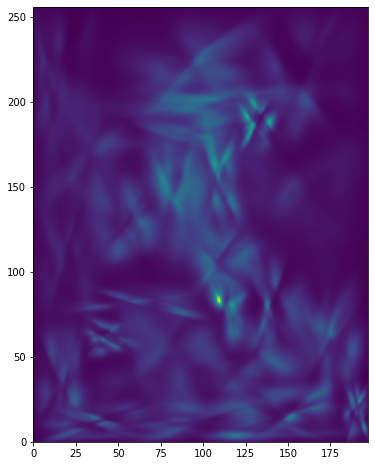

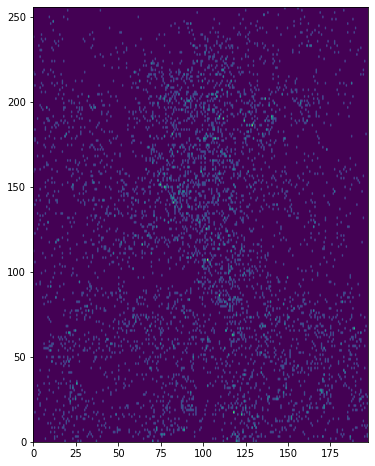

In [13]:
grid = torch.cartesian_prod(torch.linspace(0,lines,lines),torch.linspace(0,columns, columns))
density = torch.exp(dif.log_density(grid)).reshape(lines,columns).T.cpu().detach()
figure = plt.figure(figsize = (12,8))
plt.imshow(torch.flip(torch.flip(density.T,[0,1]),[0,1]),extent = [0,columns,0, lines])
dif_samples = dif.sample_model(target_samples.shape[0])
hist_dif_samples, x_edges, y_edges = numpy.histogram2d(dif_samples[:,1].numpy(), dif_samples[:, 0].numpy(), bins = (lines, columns),range = [[0, columns],[0,lines]])
figure = plt.figure(figsize = (12,8))
plt.imshow(torch.flip(torch.flip(torch.tensor(hist_dif_samples).T,[0,1]),[0,1]),extent = [0,columns,0, lines])